In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from google.colab import files
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

# CSV faylni yuklang.
print(" CSV Faylni yuklang: ")
uploaded = files.upload()


dataset_name = list(uploaded.keys())[0]

df_test = pd.read_csv(dataset_name)


df_test.head()


 CSV Faylni yuklang: 


Saving ambient_temperature_system_failure.csv to ambient_temperature_system_failure.csv


,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


In [2]:
df_test = df_test.dropna()
print("Qatorlar soni:", len(df_test))


Qatorlar soni: 7267


In [3]:
#Timestamp ustunini datetime formatiga o'tkazish
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])

# Min-Max Scaling
scaler = MinMaxScaler()
df_test['normalized_value'] = scaler.fit_transform(df_test[['value']])


In [4]:
# Feature Engineering: Rolling Averages, Seasonality, Trends

window_size = 5
df_test['rolling_avg'] = df_test['value'].rolling(window=window_size).mean()
df_test['rolling_std'] = df_test['value'].rolling(window=window_size).std()

df_test['hour'] = df_test['timestamp'].dt.hour
df_test['day'] = df_test['timestamp'].dt.day
df_test['month'] = df_test['timestamp'].dt.month
df_test['weekday'] = df_test['timestamp'].dt.weekday


In [5]:
# Model uchun kerakli ustunlarni tanlash

features = ['normalized_value', 'rolling_avg', 'rolling_std', 'hour', 'day', 'month', 'weekday']
df_test = df_test.dropna()


In [6]:
# Trening qilingan modelni yuklash

model_filename = "isolation_forest_model.pkl"
print("\nModelni yuklab olish:")
uploaded_model = files.upload()
with open(model_filename, 'rb') as file:
    model = pickle.load(file)
print("Model yuklandi!")




Modelni yuklab olish:


Saving isolation_forest_model.pkl to isolation_forest_model.pkl
Model yuklandi!


In [7]:
# Modeldan foydalanib anomaliyalarni topish

df_test['anomaly_score'] = model.decision_function(df_test[features])
df_test['anomaly'] = model.predict(df_test[features])

# Anomaliyalar sonini chiqarish
print("Test Set Anomaly Count:", np.unique(df_test['anomaly'], return_counts=True))


Test Set Anomaly Count: (array([-1,  1]), array([ 576, 6687]))


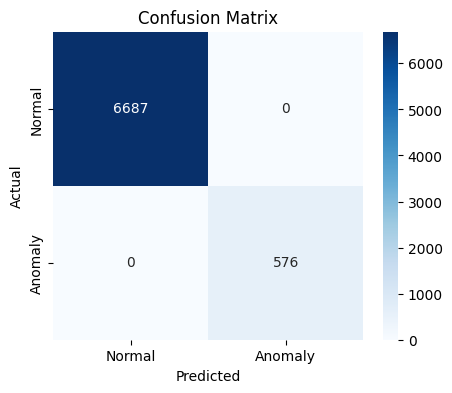

In [8]:
# Confusion matrix
cm = confusion_matrix((df_test['anomaly'] == -1), (df_test['anomaly'] == -1))
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


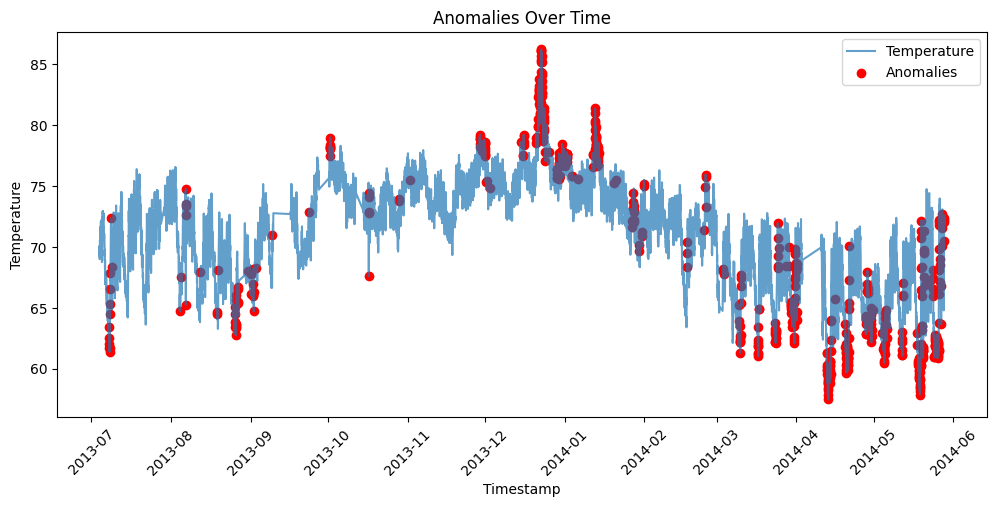

In [9]:
#  Anomaliyalarni vaqt bo‘yicha vizualizatsiya qilish

anomalies = df_test[df_test['anomaly'] == -1]
plt.figure(figsize=(12, 5))
plt.plot(df_test['timestamp'], df_test['value'], label="Temperature", alpha=0.7)
plt.scatter(anomalies['timestamp'], anomalies['value'], color='red', label='Anomalies')
plt.xlabel("Timestamp")
plt.ylabel("Temperature")
plt.title("Anomalies Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [10]:
# Anomaliyalarni va normal holatlarni belgilash
model.fit(df_test[features])
df_test['anomaly'] = model.predict(df_test[features])
df_test['anomaly'] = df_test['anomaly'].map({-1: 'Anomaly', 1: 'Normal'})

# Anomaliyaga uchragan va normal holatlar qatorlarini chiqarish
df_anomalies = df_test[df_test['anomaly'] == 'Anomaly'].sample(n=5, random_state=42)
df_normals = df_test[df_test['anomaly'] == 'Normal'].sample(n=5, random_state=42)

df_mixed = pd.concat([df_anomalies, df_normals])

df_mixed

,timestamp,value,normalized_value,rolling_avg,rolling_std,hour,day,month,weekday,anomaly_score,anomaly
7239,2014-05-27 12:00:00,72.177821,0.511716,69.052273,3.231128,12,27,5,1,-0.033613,Anomaly
4243,2014-01-13 14:00:00,78.354338,0.726441,77.761971,0.400452,14,13,1,0,-0.029511,Anomaly
3678,2013-12-21 01:00:00,78.986088,0.748403,78.238229,0.905703,1,21,12,5,-0.016722,Anomaly
6357,2014-04-20 18:00:00,60.265412,0.097585,61.080765,0.729394,18,20,4,6,-0.017847,Anomaly
6202,2014-04-14 07:00:00,59.536298,0.072237,59.888630,0.647274,7,14,4,0,-0.017329,Anomaly
4583,2014-01-27 18:00:00,73.038142,0.541625,73.238608,0.683610,18,27,1,0,0.024082,Normal
6441,2014-04-24 06:00:00,66.705298,0.321465,67.070327,0.595630,6,24,4,3,0.086651,Normal
1495,2013-09-07 14:00:00,71.165996,0.476540,71.338726,0.332251,14,7,9,5,0.093394,Normal
6392,2014-04-22 05:00:00,63.607610,0.213775,64.506767,0.602303,5,22,4,1,0.036108,Normal
6543,2014-04-28 12:00:00,67.946037,0.364599,66.365404,1.373688,12,28,4,0,-0.006127,Normal
